Python access the APIs endpoint to discover data and it's parameters.

Prerequisites:
 * python environment with xarray, fsspec, datetime
 * OGC  EDR APIservice running on local host with grid data support in NetCDF data
    * in the folowing examples:
        URL: http://localhost:5002/
        collection Name: nsea-edr
        variable: PLE_fishing_suitability
        
        

To setup EDR API on top of NetCDF, Zarr or custom data see the [LINK]

source: https://owslib.readthedocs.io/en/latest/usage.html
https://dive.pygeoapi.io/publishing/ogcapi-edr/#publish-environmental-data-in-pygeoapi


Start with the root of catalog and see what API services it offers.
See 'http://www.opengis.net/spec/ogcapi-edr-1/1.0/conf/core' is ensuring core EDR API is provided so you can get data trimmed to your 2D/3D extent and time slice in CovergaJSON or NetCDF.
Note it is generic part compliant with all the OGC API services regardles of type.

In [17]:
from owslib.ogcapi.edr import EnvironmentalDataRetrieval
URL = 'http://localhost:5002/'

e = EnvironmentalDataRetrieval(URL)
e.conformance()

{'conformsTo': ['http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/html',
  'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/json',
  'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/landing-page',
  'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-common-2/1.0/conf/collections',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-bbox',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-datetime',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-rangesubset',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/coverage-subset',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/geodata-coverage',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/html',
  'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/oas30',
  

List all the collections on the endpoint and see their IDs, titles and spatio-temporal extent.
Note it is again generic part compliant with all the OGC API services regardles of type.

In [36]:
cols = e.collections()
cols['collections']
for c in cols['collections']:
    print(c['id'] + ":" + c['title'] + ":" + str(c['keywords']) + ":"+ ":" +str(c['extent']))    

my-observations:Observations:['observations', 'monitoring']::{'spatial': {'bbox': [[-180, -90, 180, 90]], 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}, 'temporal': {'interval': [['2000-10-30T18:24:39+00:00', '2007-10-30T08:57:29+00:00']]}}
swan2-edr:EDR test with SWAN from Sea-Gust:['edr', 'swan', 'aquaculture', 'template']::{'spatial': {'bbox': [[10.4, 35.5, 11.26, 36.31]], 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}}
nsea-edr:EDR test with NortSea from ILVO:['edr', 'northsea']::{'spatial': {'bbox': [[-15.0, 61.289951973410744, 9.963, 46.00029874658926]], 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}}
nsea-zarr-edr:EDR test with NortSea from ILVO in Zarr:['edr', 'northsea']::{'spatial': {'bbox': [[-15.0, 61.289951973410744, 9.963, 46.00029874658926]], 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}}
nsea-zarr-cov:Coverages test with NortSea from ILVO in Zarr:['Coverages API', 'northsea']::{'spatial': {'bbox': [[-15.0, 61.289951973410744, 9.963, 46.

Willing to get more information about 'nsea-edr' collection we query the service with parameters it provides.

In [77]:

selected_collection = 'nsea-edr'
edr_col = e.collection(selected_collection)
print("Parameters: " + str(edr_col['parameter_names'].keys()))
for name in edr_col['parameter_names'].keys():
    param = edr_col['parameter_names'][name]
    print("Id:\t" + param['id'])
    print("\tName:\t" + param['unit']['label']['en'])
    print("\tUnit:\t" + param['unit']['symbol']['value'])
    print("\t\t" + param['unit']['symbol']['type'])

Parameters: dict_keys(['PLE_fishing_suitability'])
Id:	PLE_fishing_suitability
	Name:	Suitability of good catch (>200 kg) for Pleuronectes platessa
	Unit:	percent
		http://www.opengis.net/def/uom/UCUM/


Get data from the selected collection for specific paramter

In [169]:
import xarray as xr
import fsspec

url = 'http://localhost:5002/collections/nsea-edr/cube?bbox=-5.0,45.0,9.963,64.29&datetime=2024-04-18/2024-04-18&f=NetCDF'
bbox = "-5.0,45.0,9.963,64.27"
datetimeslice = "2024-04-18/2024-04-18"
format = "NetCDF"

data_url = URL + "collections/" + selected_collection + "/cube?bbox=" + bbox + "&datetime=" + datetimeslice + "&f=" + format
print(data_url)

http://localhost:5002/collections/nsea-edr/cube?bbox=-5.0,45.0,9.963,64.27&datetime=2024-04-18/2024-04-18&f=NetCDF


Get the actual data into xarray.

fsspec library is used for reading. Production implementation can make use of the scaled efficiency optimisation with use of fsspec cache or more advanced solutions like distributed array access and processing.

Customise: set selected_variable to the property id 

In [152]:
import xarray as xr
import fsspec
from datetime import datetime
ds = None
with fsspec.open(data_url+"&v="+str(datetime.now())) as fobj:
    ds = xr.open_dataset(fobj).load()
print(ds)

selected_variable = 'PLE_fishing_suitability'
ds.variables[selected_variable].attrs


<xarray.Dataset>
Dimensions:                  (longitude: 404, latitude: 689, time: 1)
Coordinates:
  * longitude                (longitude) float64 -4.963 -4.926 ... 9.926 9.963
  * latitude                 (latitude) float64 61.29 61.27 61.25 ... 46.02 46.0
  * time                     (time) datetime64[ns] 2024-04-18
Data variables:
    PLE_fishing_suitability  (time, latitude, longitude) float64 0.001506 ......
    crs                      int32 -2147483647
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-71)
    date:         2024-04-18 15:50:45


{'units': 'percent',
 'long_name': 'Suitability of good catch (>200 kg) for Pleuronectes platessa',
 'grid_mapping': 'crs'}

Parameters and extend is now fitting requested data size

In [160]:
#ds.variables['PLE_fishing_suitability'].attrs
ds.coords

Coordinates:
  * longitude  (longitude) float64 -4.963 -4.926 -4.889 ... 9.889 9.926 9.963
  * latitude   (latitude) float64 61.29 61.27 61.25 61.22 ... 46.04 46.02 46.0
  * time       (time) datetime64[ns] 2024-04-18

Variables values are preloaded. One can find the Unit, long_name, grid_mapping following CF convention is populated though the whole pipeline

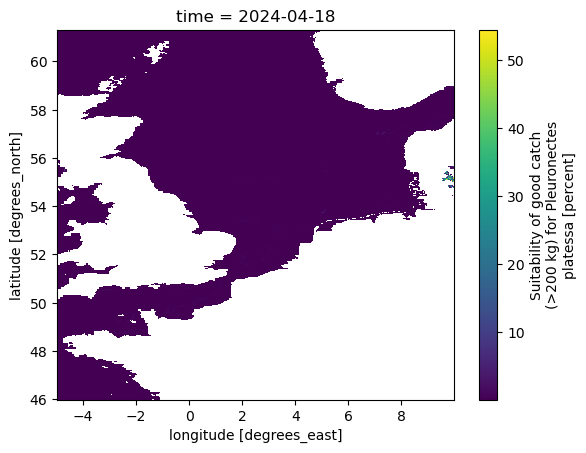

In [164]:
ds.variables['PLE_fishing_suitability']
d2d = ds.isel()
d2d.PLE_fishing_suitability.plot()

In [ ]:
Another example is the histogram that can be easily ploted.

(array([1.30766e+05, 3.20000e+01, 2.70000e+01, 2.60000e+01, 1.20000e+01,
        1.50000e+01, 9.00000e+00, 7.00000e+00, 1.00000e+01, 2.00000e+00]),
 array([8.66617484e-07, 5.44734575e+00, 1.08946906e+01, 1.63420355e+01,
        2.17893804e+01, 2.72367253e+01, 3.26840702e+01, 3.81314151e+01,
        4.35787599e+01, 4.90261048e+01, 5.44734497e+01]),
 <BarContainer object of 10 artists>)

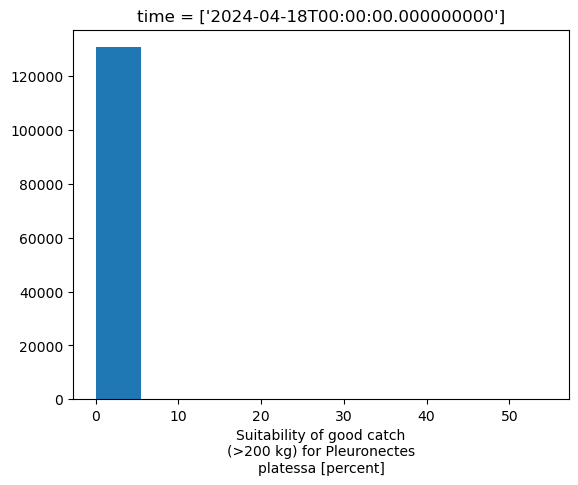

In [167]:
d2d.PLE_fishing_suitability.plot.hist()

One can also store data as needed or push for the next steps of processing

In [168]:
ds.to_zarr("output.zarr")